In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [166]:
# Load the data
nordpool = pd.read_csv('New Data/2021/Nordpool DKK.csv')
energinet = pd.read_csv('New Data/2021/Energinet DKK.csv')
weather_observation = pd.read_csv('New Data/2021/Weather Observation.csv')
weather_forecast = pd.read_csv('New Data/2021/Weather Forecast.csv')
network = pd.read_csv('New Data/2021/Network Manager.csv')

# Filter energinet price area
energinet = energinet[energinet['PriceArea | PriceArea | 804696'] == 'DK2']
# Drop price area
energinet.drop('PriceArea | PriceArea | 804696', axis=1, inplace=True)

# Convert ts to datetime
nordpool['ts'] = pd.to_datetime(nordpool['ts'])
energinet['ts'] = pd.to_datetime(energinet['ts'])
weather_observation['ts'] = pd.to_datetime(weather_observation['ts'])
weather_forecast['ts'] = pd.to_datetime(weather_forecast['ts'])
network['ts'] = pd.to_datetime(network['ts'])

# Resample network_manager data to hourly intervals (average the data)
network = network.set_index('ts')
network = network.resample('H').mean()
network.reset_index(inplace=True)

/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_72819/2096482961.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network = network.resample('H').mean()


## Step 2: Data Handling

In [181]:
# Compare length of dfs + get first & last timestamp
def get_first_last(**dfs):
    # Initialize
    first_last = pd.DataFrame(index=['first', 'last', 'length', 'start_check', 'end_check'])
    col_name='ts'
    # Save first and last timestamp for each dataframe
    for name, df in dfs.items():
        first_ts = df['ts'].iloc[0]
        last_ts = df['ts'].iloc[-1]
        start_check = start == first_ts
        end_check = end == last_ts
        first_last[name] = [first_ts, last_ts, len(df), start_check, end_check]
    return first_last

# Initialize
start = pd.to_datetime('2021-01-01 00:00:00')
end = pd.to_datetime('2021-12-31 23:00:00')

print("Length of a year in hours:", 365*24)
get_first_last(nordpool=nordpool, energine=energinet, weather_observation=weather_observation, weather_forecast=weather_forecast, network=network)

Length of a year in hours: 8760


,nordpool,energine,weather_observation,weather_forecast,network
first,2021-01-02 00:00:00,2021-01-01 00:00:00,2021-01-15 16:00:00,2021-01-01 00:00:00,2021-01-01 00:00:00
last,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-29 11:00:00,2021-12-31 23:00:00
length,8735,8759,7936,8694,8760
start_check,False,True,False,True,True
end_check,True,True,True,False,True


### Data Merging

In [182]:
# Merge the dataframes on network with left join
data = pd.merge(network, weather_forecast, on='ts', how='left')
data = pd.merge(data, weather_observation, on='ts', how='left') 

# Sort the data by the timestamp column 'ts' to ensure time order
data21 = data.sort_values(by='ts')

data21.head()

,ts,Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133,Hasle Vind Active Power | has_vin_effekt | 804123,Hasle Vind Current | has_vin_belastning | 804117,Weather forecast for the max air temperature for the coming 6 hours at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_max | 128206,Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270,Weather forecast for the precipitation amount for the coming 1 hour at Bornholm | 9F7P/00/00/MET-Norway/forecast/precipitation_amount_acc | 128238,Weather forecast for the relativehumidity amount at Bornholm | 9F7P/00/00/MET-Norway/forecast/relative_humidity_2m | 128254,Weather forecast for wind speed at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_speed | 128286,Weather forecast for wind speed y_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/y_wind_10m | 128318,...,Weather forecast for wind speed x_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/x_wind_10m | 128302,Weather forecast for the air temperature at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_2m | 128190,Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592,Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672,Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608,Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640,Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576,Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560,Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624,Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656
0,2021-01-01 00:00:00,10.505372,0.310046,19.138536,275.52020,189.13286,0.000000,0.848557,3.711973,3.658367,...,0.593647,275.51404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00,10.499852,0.739963,42.792531,275.50630,191.73468,0.269043,0.937904,3.358219,3.176009,...,0.794102,275.36557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00,10.440138,0.877331,50.523536,275.13600,184.39082,0.167969,0.974747,3.255157,3.315285,...,0.328136,275.08374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00,10.423414,0.842384,47.936477,274.88626,178.39856,0.000000,0.973976,3.109769,3.461883,...,-0.328434,274.86594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00,10.401766,0.469178,28.816449,274.93670,170.38286,0.662842,0.989250,3.090981,3.048118,...,-0.469315,274.80240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Load merged data from 2022:

In [183]:
# Load csv
data22 = pd.read_csv('New Data/2022/Wind Data 22.csv')

# Concatenate the dataframes
data = pd.concat([data21, data22], join='inner', axis=0, ignore_index=True)

# Ensure datetime format
data['ts'] = pd.to_datetime(data['ts'])

Column cleaning

In [184]:

# Use regex to remove everything starting from '|'
data.columns = data.columns.str.replace(r'\|.*', '', regex=True)
nordpool.columns = nordpool.columns.str.replace(r'\|.*', '', regex=True)
energinet.columns = energinet.columns.str.replace(r'\|.*', '', regex=True)

# Use regex to remove everything starting from the word "at"
data.columns = data.columns.str.replace(r'\sat.*', '', regex=True)
data.columns = data.columns.str.replace(r'Hasle', '', regex=True)
data.columns = data.columns.str.replace(r'Vind', 'Wind', regex=True)

# Strip columns
data.columns = data.columns.str.strip()

data.columns

Index(['ts', 'Common 10kV Lines Voltage', 'Wind Active Power', 'Wind Current',
       'Weather forecast for the max air temperature for the coming 6 hours',
       'Weather forecast for wind direction',
       'Weather forecast for the precipitation amount for the coming 1 hour',
       'Weather forecast for the relativehumidity amount',
       'Weather forecast for wind speed',
       'Weather forecast for wind speed y_direction',
       'Weather forecast for solar shortwave flux',
       'Weather forecast for the minimum air temperature for the coming 6 hours',
       'Weather forecast for wind speed x_direction',
       'Weather forecast for the air temperature',
       'Observed maximum temperature past hour',
       'Observed mean intensity of global radiation in the latest hour',
       'Observed minimum temperature past hour',
       'Observed mean wind speed the past hour',
       'Observed mean humidity past hour',
       'Observed mean temperature past hour',
       'Observed

/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_72819/3794189492.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_per_month = data.isnull().resample('M').sum()


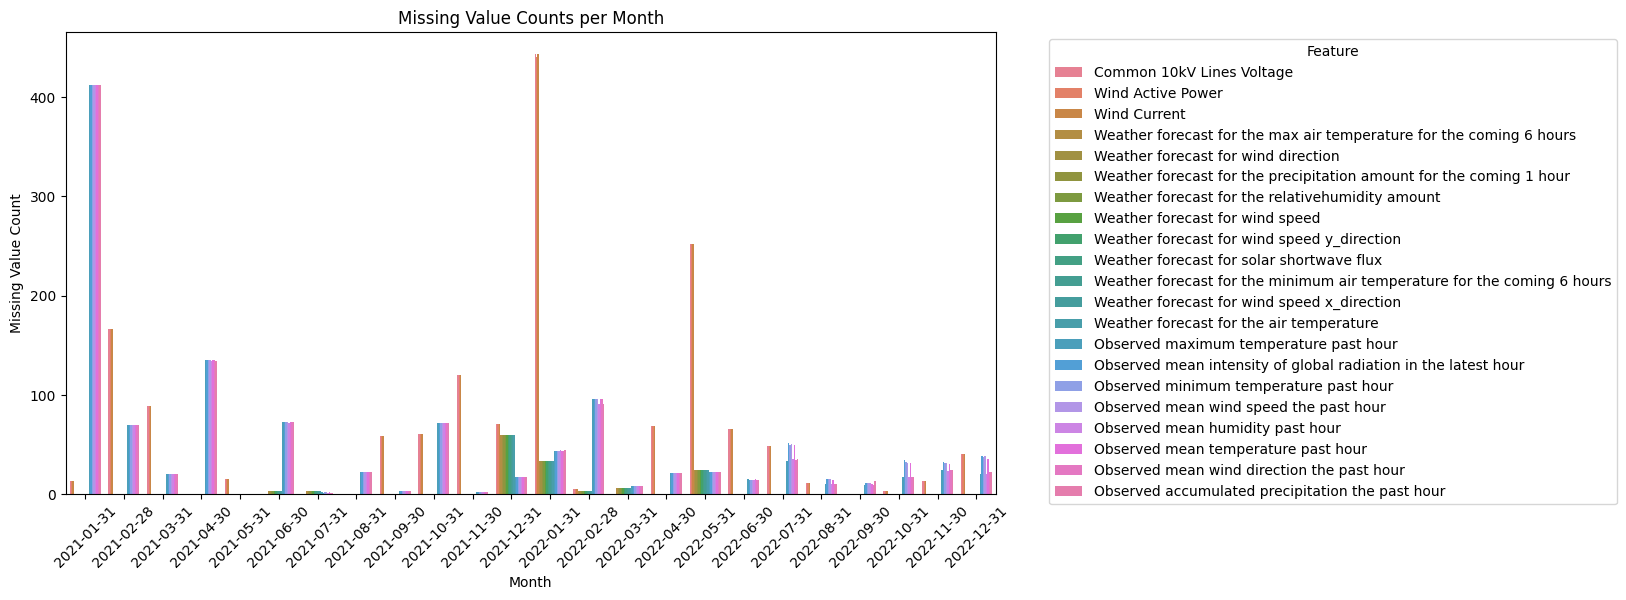

In [185]:
# Resample the data by months ('M') and count missing values for each period
data = data.set_index('ts')
missing_per_month = data.isnull().resample('M').sum()
# Reset
data = data.reset_index()

# Convert the resampled data into a long-form dataframe for easier plotting with Seaborn
missing_per_month_long = missing_per_month.reset_index().melt(id_vars='ts', var_name='Feature', value_name='Missing Count')

# Create the seaborn barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='ts', y='Missing Count', hue='Feature', data=missing_per_month_long)
plt.xticks(rotation=45)
plt.title('Missing Value Counts per Month')
plt.xlabel('Month')
plt.ylabel('Missing Value Count')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### Missing Values Handling

In [186]:
# df_interpolated = data.interpolate(method='linear')

# Set ts as index
missing_before = data.isnull().sum()
data = data.set_index('ts')
# Interpolate missing values (time series-based)
data = data.interpolate(method='time')
# Reset index
data = data.reset_index()
missing_after = data.isnull().sum()

missing_summary = pd.DataFrame({'Before': missing_before, 'After': missing_after})
missing_summary

,Before,After
ts,0,0
Common 10kV Lines Voltage,1544,0
Wind Active Power,1541,0
Wind Current,1544,0
Weather forecast for the max air temperature for the coming 6 hours,132,0
Weather forecast for wind direction,132,0
Weather forecast for the precipitation amount for the coming 1 hour,132,0
Weather forecast for the relativehumidity amount,132,0
Weather forecast for wind speed,132,0
Weather forecast for wind speed y_direction,132,0


### Feature Engineering

Lagged days

In [187]:
data = data.rename(columns={'Wind Active Power': 'Wind Power'})

# Shift by 24 hours for daily data
data['Wind Power Lag1'] = data['Wind Power'].shift(24)
data['Wind Power Lag2'] = data['Wind Power'].shift(48)
data['Wind Power Lag3'] = data['Wind Power'].shift(72)

Quantiles from prev week

In [188]:
# Rolling average for 1 week (=168h) for several quantiles
data['Wind Power 0.05 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.05)
data['Wind Power 0.5 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.5)
data['Wind Power 0.95 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.95)

Wind power production is proportional to the cube of the wind speed: $P = \frac{1}{2} \rho \pi r^2 V^3 $


Since 'Observed mean wind speed the past hour' and 'Observed Wind Speed Cubed' are highly correlated, we may encounter multicollinearity which can inflate variance estimates for regression coefficients. 

-> Lasso or Ridge regression or Nonlinear Regression needed?

In [189]:
# Cube of windspeed
data['Observed Wind Speed Cubed'] = data['Observed mean wind speed the past hour']**3

Time-based features like day and hour

In [190]:
data['Day'] = data['ts'].dt.dayofweek
data['Hour'] = data['ts'].dt.hour
data['Month'] = data['ts'].dt.month

Cut down the data as weather_observation starts **15/01/2021**?

In [191]:
# Exclude all before 15/01/2021 for data
start = pd.to_datetime('2021-01-15 00:00:00')
data = data[data['ts'] >= start]
# Exclude all after 31/12/2021 for data
data = data[data['ts'] <= end]
# Check success
len(data)

8424

In [192]:
# Check missing values
data.isnull().sum()

ts                                                                          0
Common 10kV Lines Voltage                                                   0
Wind Power                                                                  0
Wind Current                                                                0
Weather forecast for the max air temperature for the coming 6 hours         0
Weather forecast for wind direction                                         0
Weather forecast for the precipitation amount for the coming 1 hour         0
Weather forecast for the relativehumidity amount                            0
Weather forecast for wind speed                                             0
Weather forecast for wind speed y_direction                                 0
Weather forecast for solar shortwave flux                                   0
Weather forecast for the minimum air temperature for the coming 6 hours     0
Weather forecast for wind speed x_direction                     

In [204]:
# Show me the missing values with ts
missing_values = data[data.isnull().any(axis=1)]
missing_values = missing_values[['ts', 'Observed mean wind speed the past hour']]

# Drop rows with missing values
data = data.dropna()

Empty DataFrame
Columns: [ts, Observed mean wind speed the past hour]
Index: []


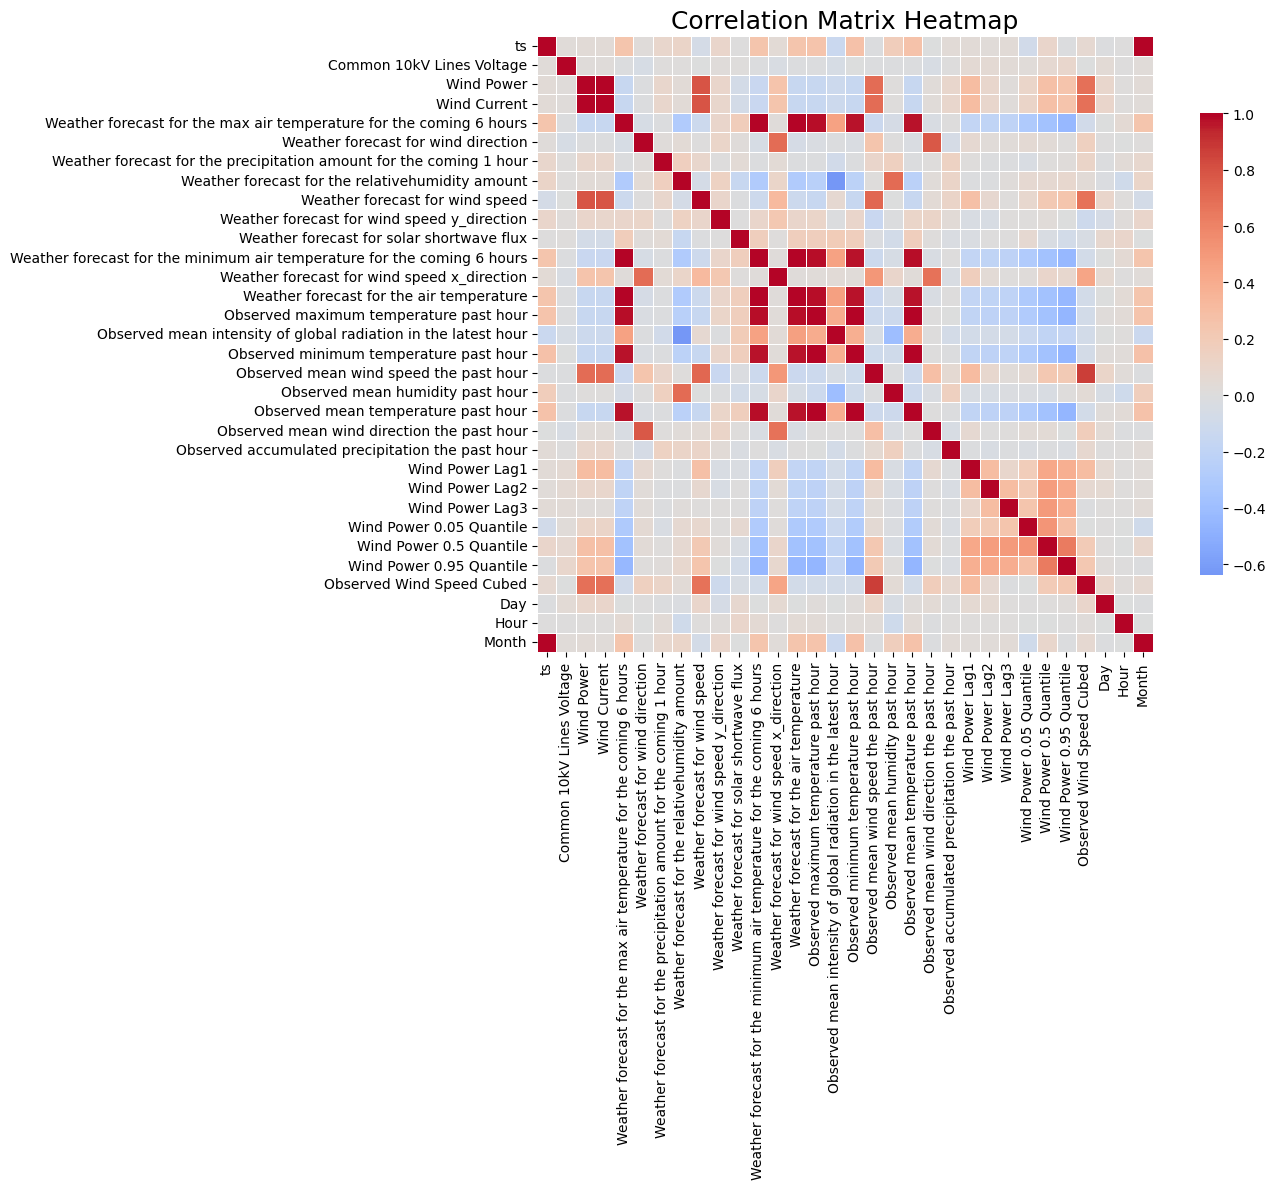

In [193]:
# Correlation matrix between features
corr_matrix = data.corr()
# print(corr_matrix)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, 
            cbar_kws={"shrink": 0.75}, square=True)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

## Step 3: Linear Regression

Split 80/20 train and test

In [205]:
# Define X, y
X = data.drop(columns=['ts', 'Wind Power']) # Features
ts = data['ts']
y = data['Wind Power']

# ts_test = ts_column[X_test.index] # if neccessary later

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Get shapes
print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

Train set: (6726, 30)
Test set: (1682, 30)


In [207]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.006115250305896792
Mean Absolute Error: 0.040775857968135355
R-squared: 0.9991267966121887


### Step 3.1: Linear Regression with Gradient Descent & Closed-form Solution

In [208]:
# Step 3.1: Implementing Linear Regression with Gradient Descent in matrix form
class LinearRegressionGD:

    # attributes of the class
    def __init__(self, learning_rate=0.01, n_iterations=1000): 
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # Parameter vector (weights and bias)
        self.cost_history = []  # To store cost function values over iterations
    
    # gradient descent algorithm
    def fit(self, X, y): 
        # Ensure that X and y are NumPy arrays and convert them to float type
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        # Number of training samples (m) and number of features (n)
        m, n = X.shape

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((m, 1)), X]  # X_b is now (m, n+1) with the bias term
        
        # Initialize theta (parameters) with zeros
        self.theta = np.zeros(n + 1)  # Including bias
        
        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_b.dot(self.theta)
            
            # Compute cost (MSE)
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)  # Store cost for plotting

            # Gradient (in matrix form)
            gradient = (1 / m) * X_b.T.dot(y_pred - y)
            
            # Update the parameters theta
            self.theta -= self.learning_rate * gradient
    
    # prediction function
    def predict(self, X):
        # Ensure that X is a NumPy array and convert it to float type
        X = np.array(X, dtype=float)
        
        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Return predictions (y_pred = X_b * theta)
        return X_b.dot(self.theta)

################################################################################

# Step 3.1: Implementing the closed-form solution (Normal Equation)
def ClosedFormSolution(X, y):
    # Ensure that X and y are NumPy arrays and convert them to float type
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    
    # Add a bias (intercept) column of ones to the input matrix X
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Normal equation: theta = (X.T * X)^(-1) * X.T * y
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best

In [211]:
# Step 3.1: Test on a small sample (e.g., first 200 rows)
X_train_small = np.array(X_train[:200], dtype=float)  
y_train_small = np.array(y_train[:200], dtype=float)

# Train using Gradient Descent
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
gd_model.fit(X_train_small, y_train_small)
y_pred_gd = gd_model.predict(X_train_small)

# Train using Closed-Form Solution (Normal Equation)
theta_best = ClosedFormSolution(X_train_small, y_train_small)
X_b_small = np.c_[np.ones((X_train_small.shape[0], 1)), X_train_small]
y_pred_closed_form = X_b_small.dot(theta_best)

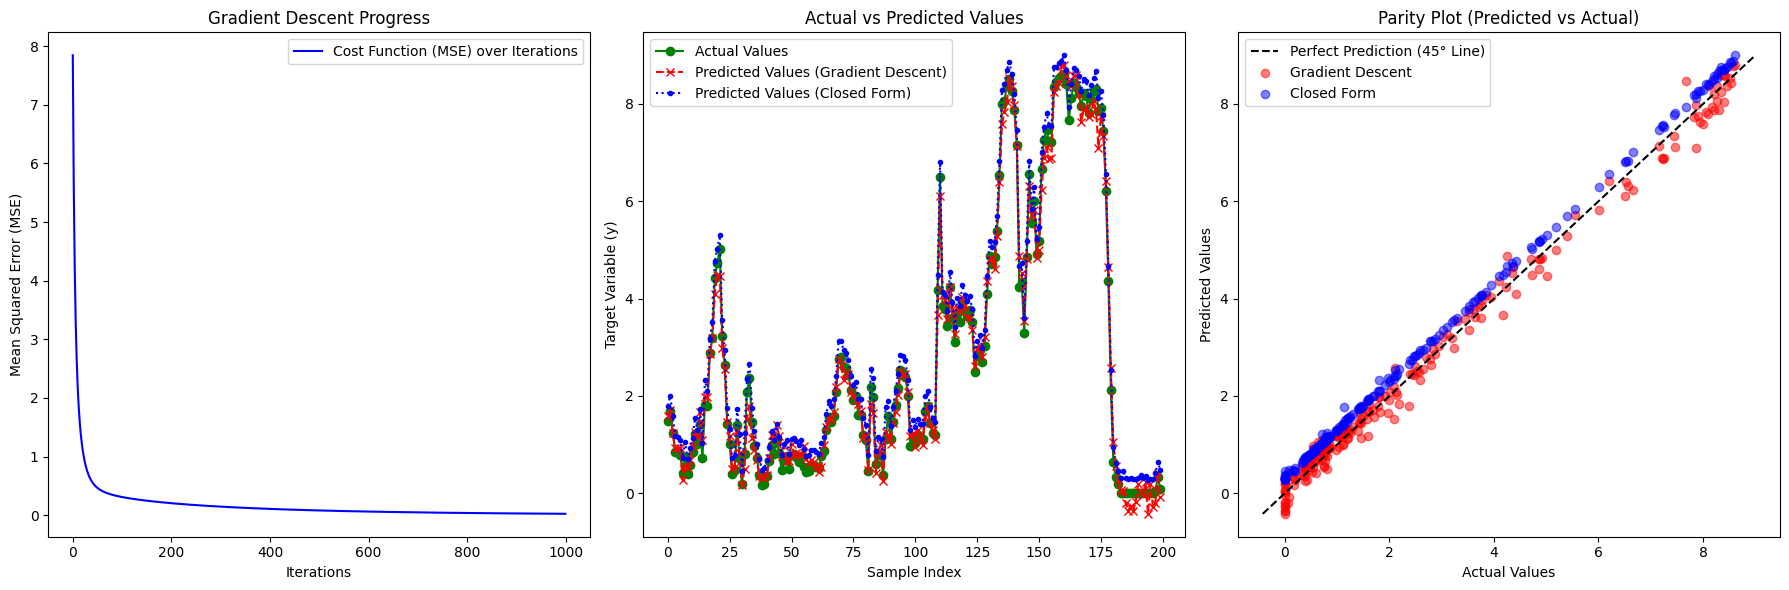

Gradient Descent Coefficients: [ 4.46710790e-01 -6.76451072e-02  2.07276520e+00 -9.28260277e-03
  1.30494813e-02 -4.32025330e-04  1.17594947e-01  3.88061025e-01
 -4.35217661e-02  4.69511674e-02 -4.53964184e-02  1.38761342e-01
 -2.27906573e-02 -1.15449363e-01 -2.99076737e-01 -9.21487771e-02
  8.62450191e-02 -7.84574663e-02 -1.02098083e-01 -9.19170437e-02
  3.54385701e-02  1.18205176e-01 -3.73262491e-02 -1.29315825e-01
  1.95245373e-01 -1.19131010e-01 -3.14967422e-02  6.28605492e-02
  1.38634365e-01 -6.53033108e-02 -7.73575678e-01]
Closed-Form Solution Coefficients: [ 1.85058526e+00  1.58002394e-01  2.56495765e+00  3.61877000e-02
  2.85366570e-03  4.97901724e-03 -1.01263941e-02  1.95710699e-02
  7.80638379e-03  1.41216116e-02 -1.00683378e-01  3.16709723e-03
  9.00144643e-03 -2.21318467e-01 -1.92148943e-02  1.41050769e-01
 -4.55012744e-02 -1.09700309e-03  8.97992137e-02 -1.49276194e-02
  9.98815350e-03 -3.76100473e-03 -7.12549303e-03 -2.30245950e-02
 -2.08602340e-02  5.16729816e-02  4.082

In [212]:
# Create a figure with three subplots: Gradient Descent progress, Actual vs. Predicted, Parity plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train_small, label='Actual Values', marker='o', color='g')
axs[1].plot(y_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train_small.min(), y_pred_gd.min(), y_pred_closed_form.min())
max_val = max(y_train_small.max(), y_pred_gd.max(), y_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train_small, y_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train_small, y_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Verify that both solutions are close by comparing the predictions
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best)
print("Are the predictions close? ", np.allclose(y_pred_gd, y_pred_closed_form))


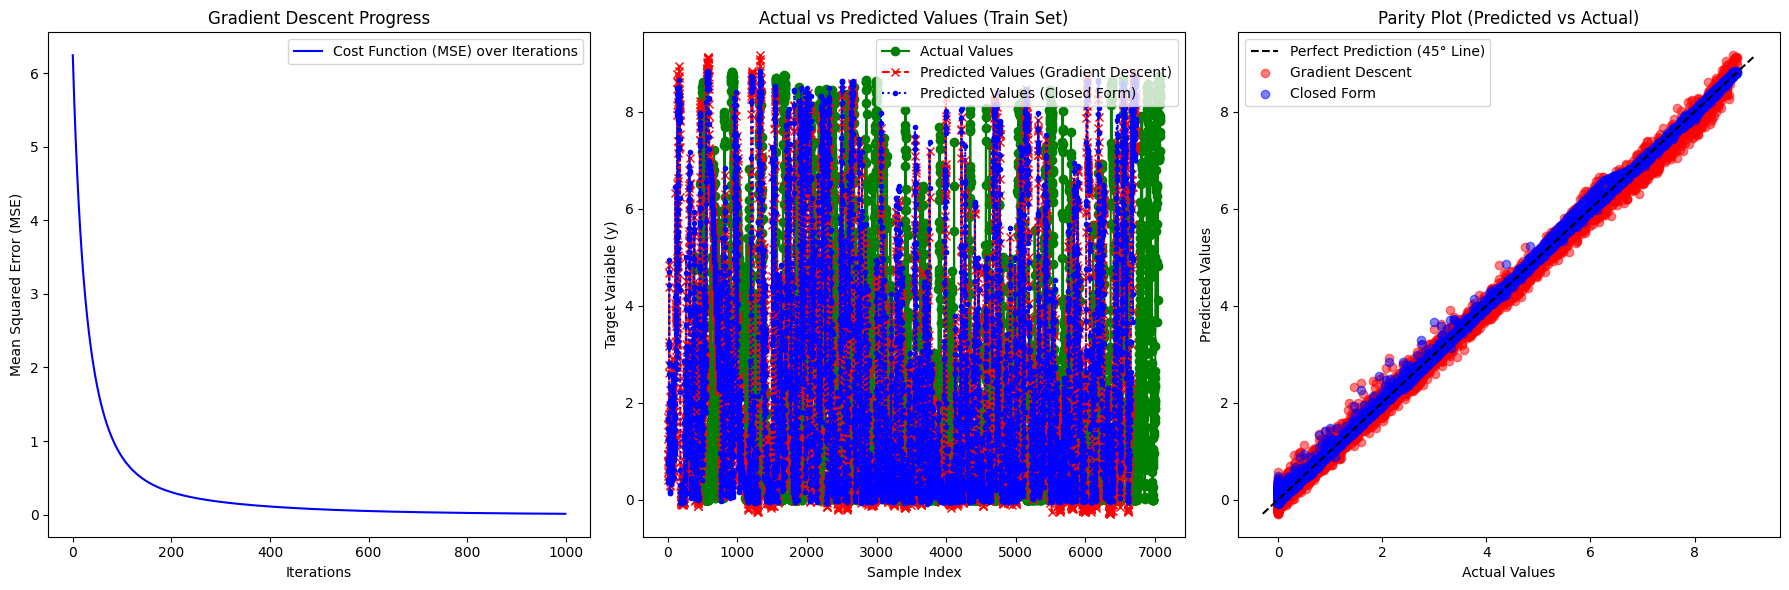

Gradient Descent Coefficients: [ 2.55171258e+00 -3.13357479e-03  2.34374811e+00  3.41288213e-03
  2.56729679e-03 -4.18750387e-04 -1.33721051e-02  1.80906809e-01
  1.76189525e-02 -1.47345456e-03 -3.92707276e-03 -4.22978001e-02
 -3.28841653e-03  3.57139969e-02 -7.69250443e-02  4.94819462e-02
  1.75105276e-02  3.17971965e-03  4.20651385e-02  1.06510282e-02
 -1.04540549e-02 -1.69174634e-03 -5.41198420e-03 -8.53539700e-03
 -1.45370721e-02  3.71944562e-02  1.38495441e-02  3.86750014e-02
 -1.66620879e-03 -4.06587806e-03 -1.21847871e-01]
Closed-Form Solution Coefficients: [ 2.61926473e+00 -1.58228329e-03  2.56421694e+00  2.84564890e-04
  4.07274823e-03 -5.64043990e-04  6.27703889e-04  2.03420010e-03
  7.62726364e-03  4.52973495e-04 -4.54809627e-04 -1.92613917e-03
 -1.47841574e-02 -8.45743715e-02  3.30653119e-03  9.55449619e-02
 -1.50999037e-03  2.56808358e-03  6.94789596e-04  2.10660194e-03
 -2.43074353e-03 -3.42042558e-03 -3.35609620e-03 -3.99747976e-03
 -1.43951314e-02  1.75657789e-03  3.330

In [213]:
# Assuming X_train_df and y_train are defined and scaled already

# Closed-Form Solution (Normal Equation)
theta_best_full = ClosedFormSolution(X_train, y_train)
X_b_full = np.c_[np.ones((X_train.shape[0], 1)), X_train]
y_train_pred_closed_form = X_b_full.dot(theta_best_full)

# Train using Gradient Descent on full dataset
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)  # You can increase iterations if needed
gd_model.fit(X_train, y_train)
y_train_pred_gd = gd_model.predict(X_train)

# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[1].plot(y_train_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_train_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values (Train Set)')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_closed_form.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train, y_train_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train, y_train_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Output the coefficients for both methods
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best_full)

# Compare the predictions and check if they are close
print("Are the predictions close? ", np.allclose(y_train_pred_gd, y_train_pred_closed_form))


In [214]:
# Step 3.3: Evaluate the model on the testing dataset
X_b_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
y_test_pred = X_b_test.dot(theta_best_full)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 0.07820006589444992
Mean Absolute Error (MAE): 0.040775857968137236
R-squared (R²): 0.9991267966121888


## Step 4

In [215]:
# Step 4.1: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Train the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_train_pred_poly = model_poly.predict(X_train_poly)

# Step 4.2: Define random weights and fit the weighted linear regression model
weights = np.random.rand(X_train.shape[0])  # Random weights for demonstration -> how to set up 
model_weighted = LinearRegression()
model_weighted.fit(X_train, y_train, sample_weight=weights)
y_train_pred_weighted = model_weighted.predict(X_train)

# Evaluation metrics for all models
rmse_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_gd))
mae_linear = mean_absolute_error(y_train, y_train_pred_gd)
r2_linear = r2_score(y_train, y_train_pred_gd)

rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
r2_poly = r2_score(y_train, y_train_pred_poly)

rmse_weighted = np.sqrt(mean_squared_error(y_train, y_train_pred_weighted))
mae_weighted = mean_absolute_error(y_train, y_train_pred_weighted)
r2_weighted = r2_score(y_train, y_train_pred_weighted)

print(f"Linear Model RMSE: {rmse_linear}")
print(f"Polynomial Model RMSE: {rmse_poly}")
print(f"Weighted Model RMSE: {rmse_weighted}")


Linear Model RMSE: 0.15948912743085453
Polynomial Model RMSE: 0.056583928120689395
Weighted Model RMSE: 0.06794983685337698


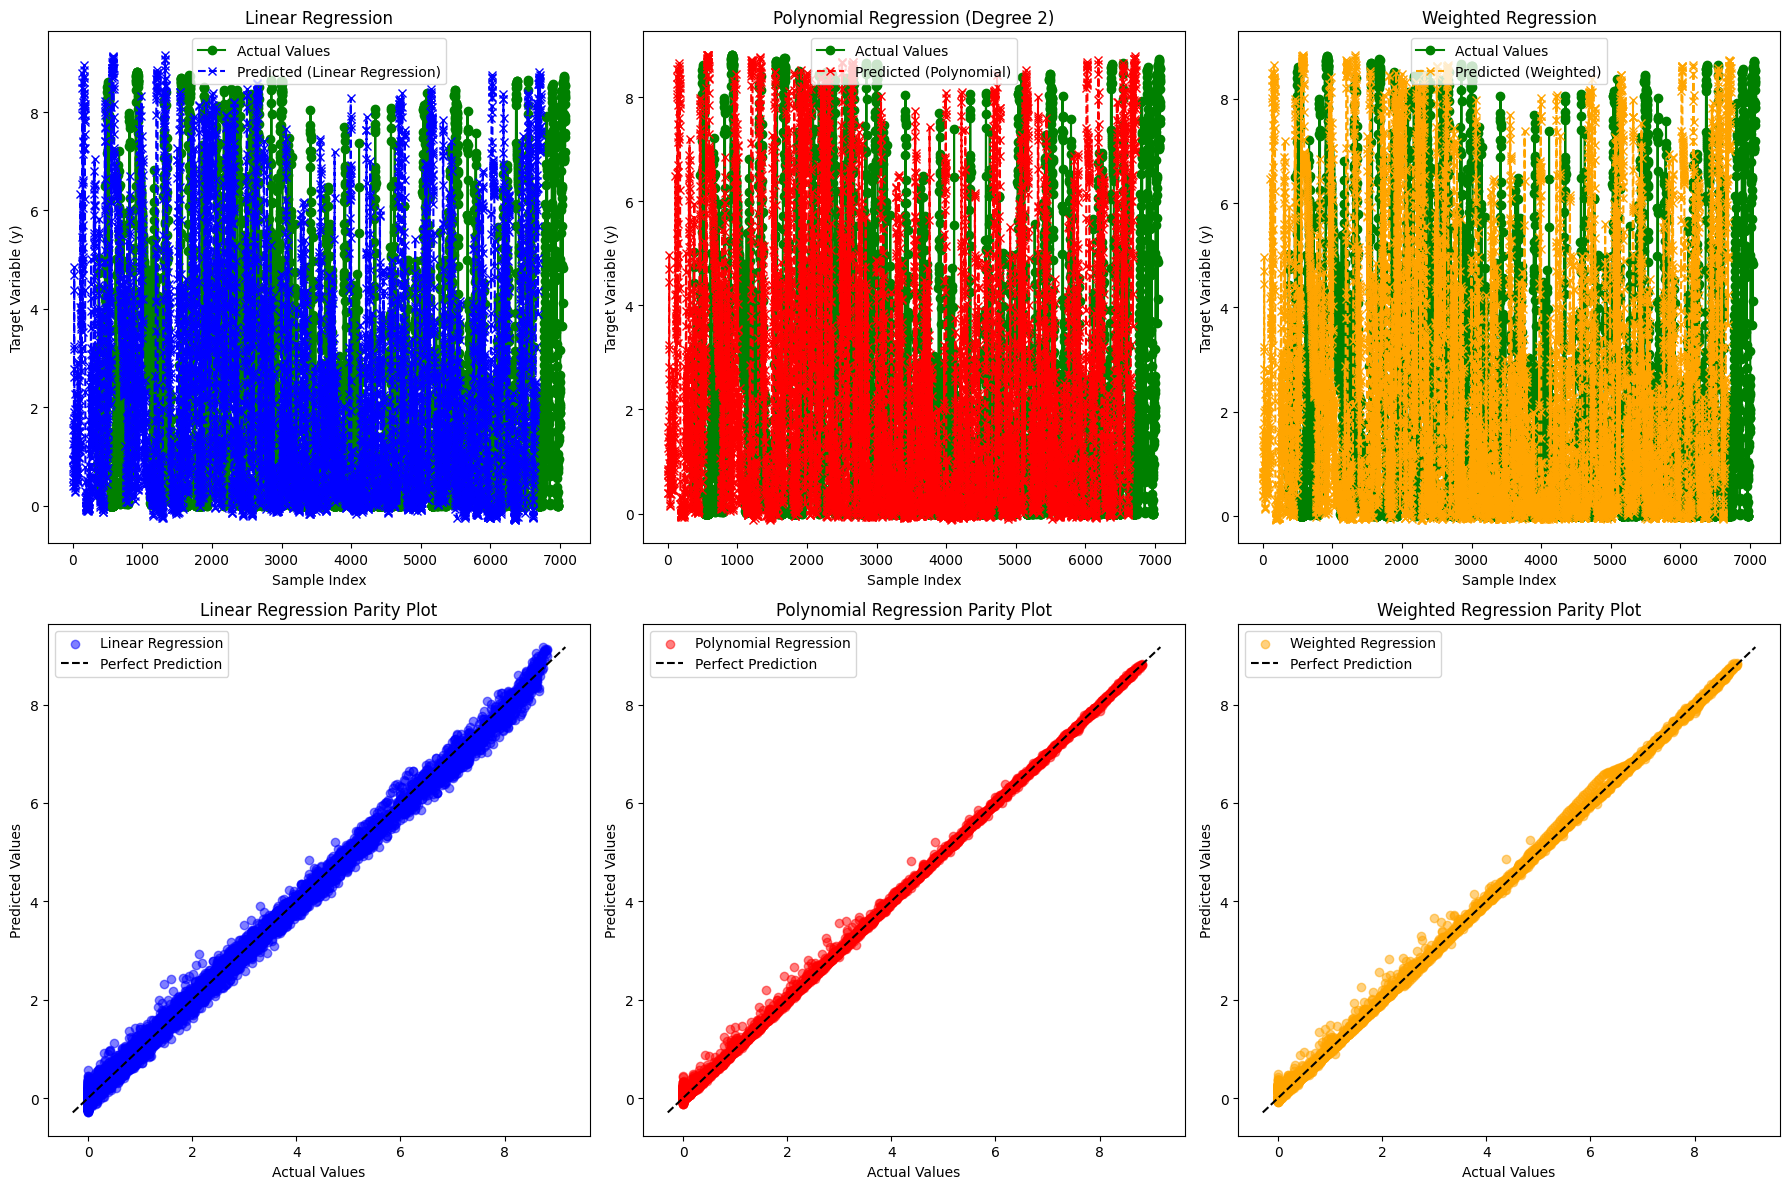

In [216]:
# Create a figure with six subplots (3x2): One row for actual vs. predicted, another for parity plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

### First row: Actual vs. Predicted values
# Subplot 1: Actual vs Predicted for Linear Regression (from Step 3)
axs[0, 0].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 0].plot(y_train_pred_gd, label='Predicted (Linear Regression)', marker='x', linestyle='--', color='b')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Target Variable (y)')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].legend()

# Subplot 2: Actual vs Predicted for Polynomial Regression (Step 4.1)
axs[0, 1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 1].plot(y_train_pred_poly, label='Predicted (Polynomial)', marker='x', linestyle='--', color='r')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Target Variable (y)')
axs[0, 1].set_title('Polynomial Regression (Degree 2)')
axs[0, 1].legend()

# Subplot 3: Actual vs Predicted for Weighted Regression (Step 4.2)
axs[0, 2].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 2].plot(y_train_pred_weighted, label='Predicted (Weighted)', marker='x', linestyle='--', color='orange')
axs[0, 2].set_xlabel('Sample Index')
axs[0, 2].set_ylabel('Target Variable (y)')
axs[0, 2].set_title('Weighted Regression')
axs[0, 2].legend()

### Second row: Parity plots (Predicted vs Actual, with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_poly.min(), y_train_pred_weighted.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_poly.max(), y_train_pred_weighted.max())

# Subplot 4: Parity plot for Linear Regression
axs[1, 0].scatter(y_train, y_train_pred_gd, color='b', alpha=0.5, label='Linear Regression')
axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Predicted Values')
axs[1, 0].set_title('Linear Regression Parity Plot')
axs[1, 0].legend()

# Subplot 5: Parity plot for Polynomial Regression
axs[1, 1].scatter(y_train, y_train_pred_poly, color='r', alpha=0.5, label='Polynomial Regression')
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title('Polynomial Regression Parity Plot')
axs[1, 1].legend()

# Subplot 6: Parity plot for Weighted Regression
axs[1, 2].scatter(y_train, y_train_pred_weighted, color='orange', alpha=0.5, label='Weighted Regression')
axs[1, 2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 2].set_xlabel('Actual Values')
axs[1, 2].set_ylabel('Predicted Values')
axs[1, 2].set_title('Weighted Regression Parity Plot')
axs[1, 2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
